In [1]:
import sys
sys.path.insert(1, "/home/gemeinl/code/brainfeatures/")

In [2]:
import numpy as np
import time
import pandas as pd

In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import accuracy_score

In [4]:
from pyriemann.utils.mean import mean_covariance
from pyriemann.tangentspace import TangentSpace

In [5]:
from brainfeatures.data_set.tuh_abnormal import TuhAbnormal
from brainfeatures.utils.data_util import reject_windows_with_outliers, split_into_epochs

__load saved mean covariance matrices and labels from npy file instead of recomputing__

In [108]:
covs = np.load("/home/gemeinl/data/covs/mean_train_covs.npy")

In [7]:
y = np.load("/home/gemeinl/data/covs/train_pathology_labels_without_822.npy")

In [129]:
ages = np.load("/home/gemeinl/data/covs/train_age_labels_without_822.npy")

In [132]:
list(ages).index(0)

189

In [109]:
covs.shape, len(y)

((2716, 21, 21), 2716)

In [10]:
ts = TangentSpace()
covs = ts.fit_transform(covs)

covs = np.array([cov[np.triu_indices_from(cov,0)] for cov in covs])

In [11]:
covs = np.array([cov.ravel() for cov in covs])

In [12]:
covs.shape, len(y)

((2716, 231), 2716)

tmp = np.concatenate((covs, len(covs)*[[-1]], y.reshape(-1, 1)), axis=1)

In [13]:
np.max(covs), np.min(covs)

(7.0534824412587005, -5.995324246567388)

In [15]:
scaled_covs = covs - np.min(covs, axis=1, keepdims=True)
scaled_covs = scaled_covs / np.max(scaled_covs, axis=1, keepdims=True)

In [17]:
import matplotlib.pyplot as plt

In [18]:
import seaborn as sns
sns.set(color_codes=True)

In [19]:
fs =20
plt.rcParams.update({"font.size": fs})
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.rc('axes',labelsize=fs)

In [20]:
electrodes = ['A1', 'A2', 'C3', 'C4', 'CZ', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2',
                     'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', '\nT3', 'T4', '\nT5', 'T6']

Text(103, 0.15000000000000002, 'Normal')

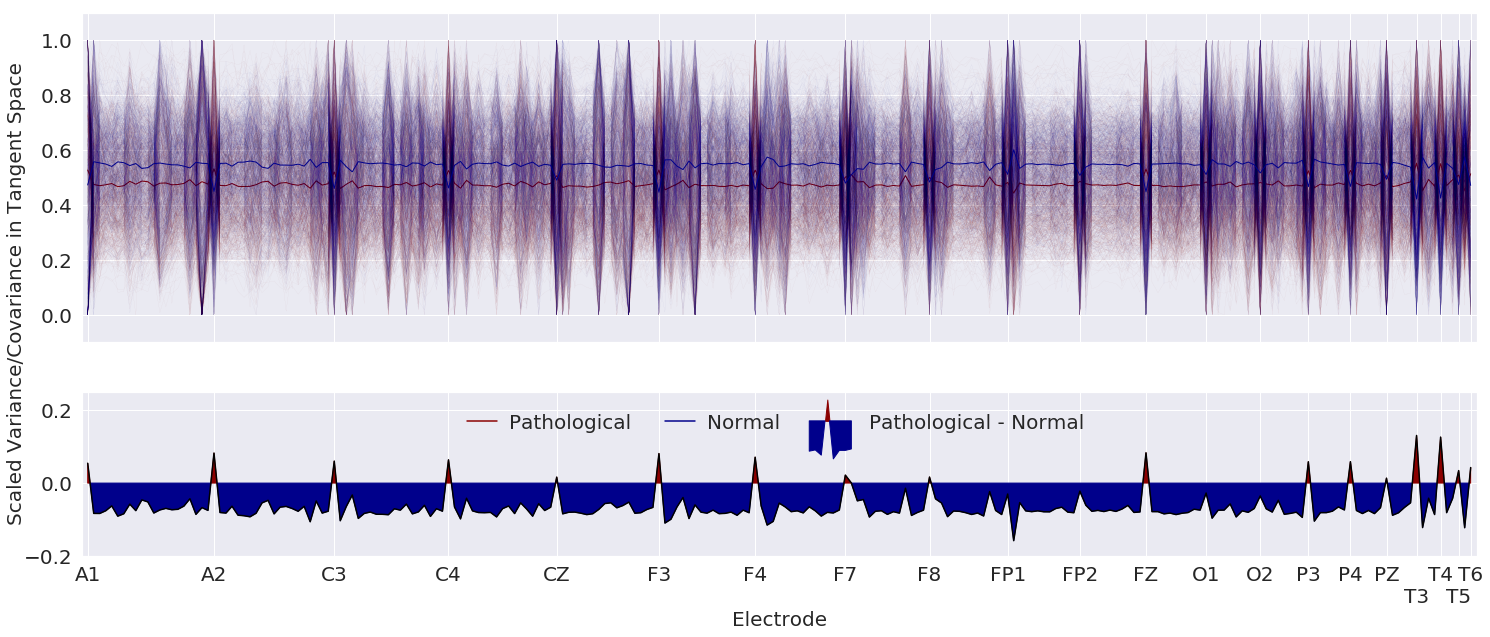

In [97]:
linewidth=.02
alpha=.7
offset=.001

fig, ax_arr = plt.subplots(2, 1, figsize=(25, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax1, ax2 = ax_arr
for line in scaled_covs[y][::2]:
    ax1.plot(line, c="darkred", linewidth=linewidth, alpha=alpha)
ax1.plot(np.mean(scaled_covs[y], axis=0), c="darkred", linewidth=1, alpha=1, label="Pathological")
pathological_normal = np.mean(scaled_covs[y], axis=0) - np.mean(scaled_covs[~y], axis=0)
ax2.plot(pathological_normal, c="black", label="Pathological - Normal")
#ax1.plot([0, len(pathological_normal)], [0,0], c="k", linestyle="--")
#ax1.fill_between(np.arange(len(pathological_normal)), pathological_normal, color="darkred")

for line in scaled_covs[~y][::2]:
    ax1.plot(line, c="darkblue", linewidth=linewidth, alpha=alpha)
ax1.plot(np.mean(scaled_covs[~y], axis=0), c="darkblue", linewidth=1, alpha=1, label="Normal")
normal_pathological = np.mean(scaled_covs[y], axis=0) + np.mean(scaled_covs[~y], axis=0)
#ax1.plot(normal_pathological, c="darkblue")#, label="Normal - Pathological")
#ax1.plot([0, len(normal_pathological)], [0,0], c="k", linestyle="--")
#ax1.fill_between(np.arange(len(normal_pathological)), normal_pathological, color="darkblue")

#ax1.axhline(0, linestyle="--", c="k")
ax2.fill_between(np.arange(len(normal_pathological)), pathological_normal, where=pathological_normal>=0, color="darkred", interpolate=True)
ax2.fill_between(np.arange(len(normal_pathological)), pathological_normal, where=pathological_normal<=0, color="darkblue", interpolate=True)

#legend = fig.legend(fontsize=fs, loc="upper center", ncol=3)#, bbox_to_anchor=(.45, .16), ncol=2)
           #bbox_to_anchor=(1,.44))

l = list(range(21, 0, -1))
ticks = [sum(l[:i]) for i in range(len(l))]
#ticks = 21 * np.arange(21) + np.arange(21)
ax1.set_xlim(-1, len(normal_pathological))
ax1.set_xticks(ticks)
ax1.set_xticklabels(electrodes);
ax1.set_ylim(-.1,1.1);
ax2.set_ylim(-.2,.25)
#ax1.set_yticklabels(["{:.2f}".format(i) for i in [1.25, 1, .75, .5, .25, 0, .25, .5, .75, 1]])

ax2.set_xlabel("Electrode");
ax1.set_ylabel("Scaled Variance/Covariance in Tangent Space", y=.15, labelpad=14);


offset_y = .17
offset_x = 120
start = 200
stop=208
#ax2.fill_between(np.arange(len(normal_pathological[start:stop]))+offset_x, normal_pathological[start:stop]+offset_y, 
#                 y2=np.ones(stop-start)*offset_y, color="darkblue",)
ax2.fill_between(np.arange(len(pathological_normal[start:stop]))+offset_x, pathological_normal[start:stop]+offset_y, 
                 y2=np.ones(stop-start)*offset_y, color="darkred", where=pathological_normal[start:stop]>=0, interpolate=True)
ax2.fill_between(np.arange(len(pathological_normal[start:stop]))+offset_x, pathological_normal[start:stop]+offset_y, 
                 y2=np.ones(stop-start)*offset_y, color="darkblue", where=pathological_normal[start:stop]<=0, interpolate=True)

ax2.text(offset_x+10, offset_y-.02, "Pathological - Normal")
ax2.plot([offset_x-57, offset_x-52], [offset_y, offset_y], c="darkred")
ax2.text(offset_x-50, offset_y-.02, "Pathological")
ax2.plot([offset_x-24, offset_x-19], [offset_y, offset_y], c="darkblue")
ax2.text(offset_x-17, offset_y-.02, "Normal")